In [71]:
import os
from pathlib import Path

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score, precision_recall_curve

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV

In [32]:
def load_titanic_train_preprocessed():
    train_preprocessed = pd.read_csv(os.path.join('data', 'train_preprocessed.csv'))
    train_preprocessed_features = train_preprocessed.drop('Survived', axis=1)
    train_preprocessed_label = train_preprocessed['Survived']
    return train_preprocessed_features, train_preprocessed_label

In [3]:
def load_titanic_train_test_preprocessed():
    train_test_preprocessed = pd.read_csv(os.path.join('data', 'train_test_preprocessed.csv'))
    train_test_preprocessed_features = train_test_preprocessed.drop('Survived', axis=1)
    train_test_preprocessed_label = train_test_preprocessed['Survived']
    return train_test_preprocessed_features, train_test_preprocessed_label

In [4]:
X_train, y_train = load_titanic_train_preprocessed()
X_test, y_test = load_titanic_train_test_preprocessed()

# Train the model

In [54]:
def create_report(model, X, y):
    final_predictions = model.predict(X)
    ConfusionMatrixDisplay.from_predictions(y, final_predictions)
    plt.show()
    print("The test score is ", accuracy_score(y, final_predictions))

    ## for the next methods:
    ## if pos_label is not given, it just calculates the f1_score for pos_label=1
    ## with average="weighted", we can define to calculate the average weighted for all labels
    ## with average="macro", we get the unweighted mean (label imbalance is not taken into account)


    ## precision score: TP / (TP + FP) ==> the more false positives I have, the smaller the precision score
    print("The precision score is ", precision_score(y, final_predictions, average="weighted"))

    ## recall score: TP / (TP + FN) ==> the more false negatives I have, the smaller the recall score
    print("The recall score is ", recall_score(y, final_predictions, average="weighted"))

    ## f1 score: combination of precision and recall score
    print("The f1 score is ", f1_score(y, final_predictions, average="weighted"))
    print(classification_report(y, final_predictions))

In [6]:
def correct_wrong_predicted_sets(model, X, y):
    final_predictions = model.predict(X)
    df = X.copy()
    df["Survived"] = y
    df["Predicted_Survived"] = final_predictions
    return df[df['Survived'] == df['Predicted_Survived']], df[df['Survived'] != df['Predicted_Survived']]

In [7]:
class_weights = {
    1: 0.6,
    0: 0.9
}

In [66]:
def plot_precision_recall_curve(recalls, precisions):
    plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

In [104]:
def plot_threshold(recalls, precisions, thresholds, threshold_v_line):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.vlines(threshold_v_line, 0, 1.0, "k", "dotted", label="threshold")
    plt.show()

## LogisticRegression

In [118]:
lr_model = LogisticRegression(max_iter=1000, penalty="l2", class_weight=class_weights)
lr_model.fit(X_train, y_train)
print("The score of our model is ", lr_model.score(X_train, y_train))

The score of our model is  0.8146067415730337


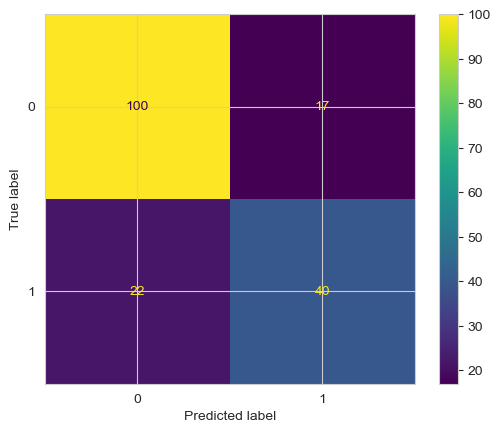

The test score is  0.7821229050279329
The precision score is  0.7788291132630552
The recall score is  0.7821229050279329
The f1 score is  0.7798247042441483
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       117
           1       0.70      0.65      0.67        62

    accuracy                           0.78       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.78      0.78      0.78       179



In [119]:
create_report(lr_model, X_test, y_test)

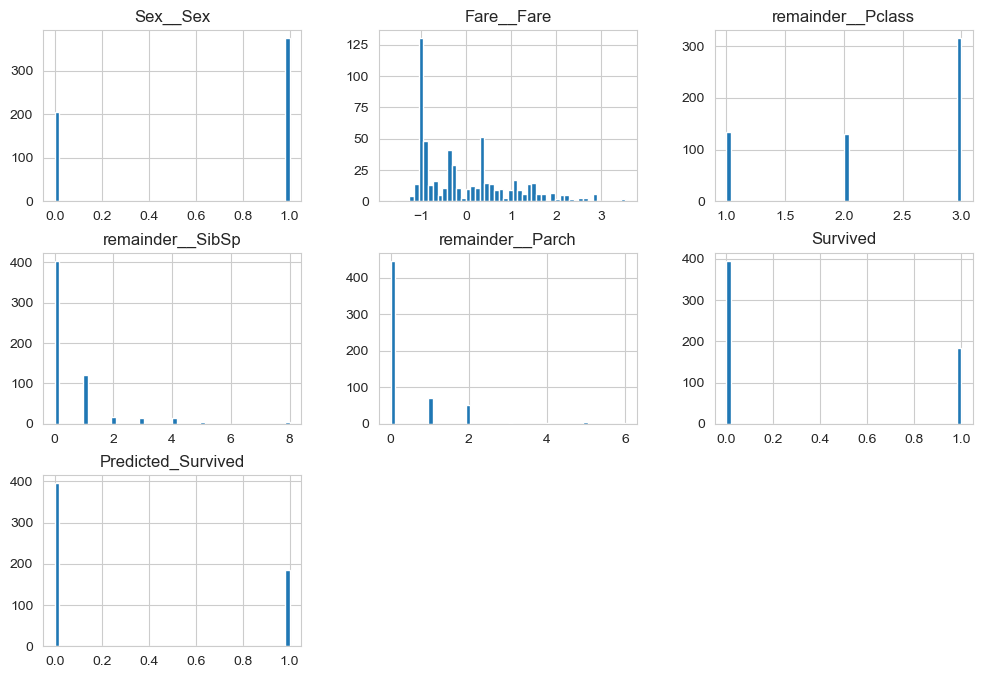

In [120]:
df_correct_predicted, df_wrong_predicted = correct_wrong_predicted_sets(lr_model, X_train, y_train)
df_correct_predicted.hist(bins=50, figsize=(12, 8))
plt.show()

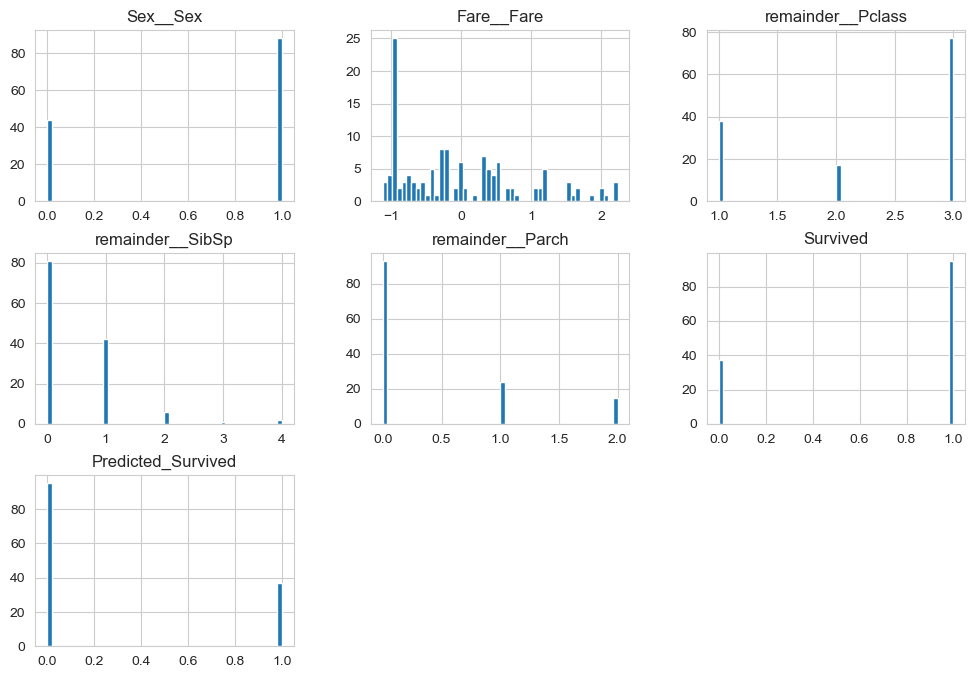

In [121]:
df_wrong_predicted.hist(bins=50, figsize=(12, 8))
plt.show()

### Computing cross-validated metrics

In [122]:
scores = cross_val_score(lr_model, X_train, y_train, cv=5)
scores

array([0.83216783, 0.85314685, 0.82394366, 0.77464789, 0.79577465])

In [123]:
scores = cross_validate(lr_model, X_train, y_train, cv=5)
scores

{'fit_time': array([0.00499845, 0.00500107, 0.00500083, 0.00500035, 0.00500011]),
 'score_time': array([0.00100017, 0.00199819, 0.00099921, 0.00099969, 0.00099993]),
 'test_score': array([0.83216783, 0.85314685, 0.82394366, 0.77464789, 0.79577465])}

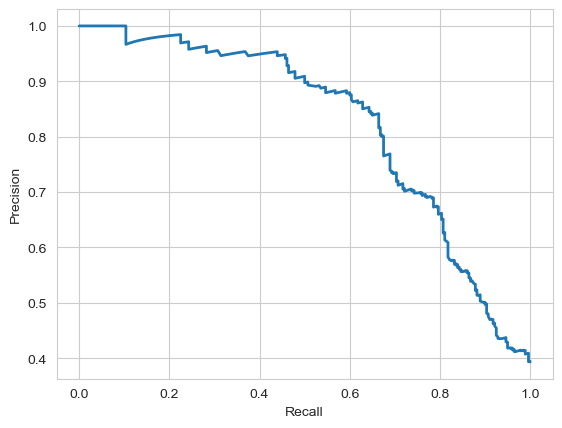

In [124]:
# Let's do cross-validated predictions.
# It generates predictions for each sample in the input data using a specified model and cross-validation strategy.

# By using cross_val_predict(), you can obtain predictions for the entire dataset, taking into account the model's
# performance on different subsets of the data.
y_scores = cross_val_predict(lr_model, X_train, y_train, cv=5, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plot_precision_recall_curve(recalls, precisions)

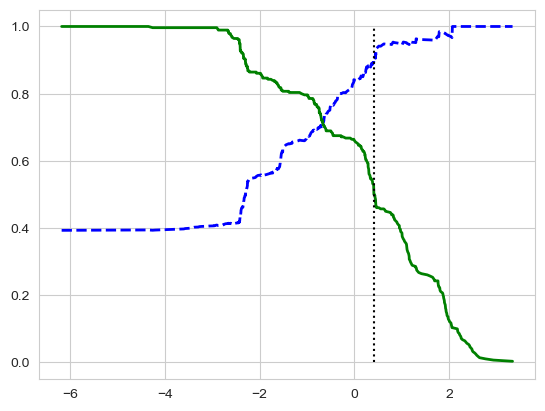

In [125]:
plot_threshold(recalls, precisions, thresholds, 0.415328958913189)

In [126]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

0.415328958913189

In [127]:
# y_scores are the results from "decision_function". The model did not say "0" or "1" (as in predict()) but returned the score
# if this score is greater or equal to the threshold, the resulting boolean array (y_train_pred_90) gets a "True", otherwise a "False"
# so y_scores represent a score, and y_train_pred_90 predicted labels
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print("Precision score: ", precision_score(y_train, y_train_pred_90))
print("Recall score: ", recall_score(y_train, y_train_pred_90))

Precision score:  0.9032258064516129
Recall score:  0.5


In [128]:
# use this on the test data
test_data_scores = lr_model.decision_function(X_test)  # this is called instead of predict() --> we are getting scores here, no labels!
test_data_predictions = (test_data_scores >= threshold_for_90_precision)  # now we are creating the labels
print("Precision score on test data is ", precision_score(y_test, test_data_predictions))
print("Recall score on test data is ", recall_score(y_test, test_data_predictions))

Precision score on test data is  0.8857142857142857
Recall score on test data is  0.5


## LogisticRegression with GridSearch

In [34]:
scoring = {
    'precision': make_scorer(precision_score, average=None, labels=[1]),
    'recall'   : make_scorer(recall_score, average=None, labels=[1]),
    'f1'       : make_scorer(f1_score, average=None, labels=[1]),
    'accuracy' : make_scorer(accuracy_score),
}

lr_model_gs = LogisticRegression(class_weight=class_weights, random_state=42, max_iter=1000)
param_grid = {
    "penalty"     : ["l1", "l2"],
    "C"           : np.linspace(0.01, 1, 2).round(3),   # Return evenly spaced numbers over a specified interval.
    "class_weight": ["balanced", class_weights],
    "solver"      : ["saga", "liblinear"]
}

grid_model_log = GridSearchCV(
    estimator=lr_model_gs,
    param_grid = param_grid,
    scoring = scoring['recall'],
    error_score="raise",
    n_jobs=-1,
    cv=5
)

In [36]:
%%time
grid_model_log.fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 2.46 s


GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(class_weight={0: 0.9, 1: 0.6},
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.01, 1.  ]),
                         'class_weight': ['balanced', {0: 0.9, 1: 0.6}],
                         'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring=make_scorer(recall_score, average=None, labels=[1]))

In [37]:
# Get the best hyperparameters
best_paramsl_log = grid_model_log.best_params_
best_paramsl_log, grid_model_log.best_score_

({'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'},
 0.7535714285714287)

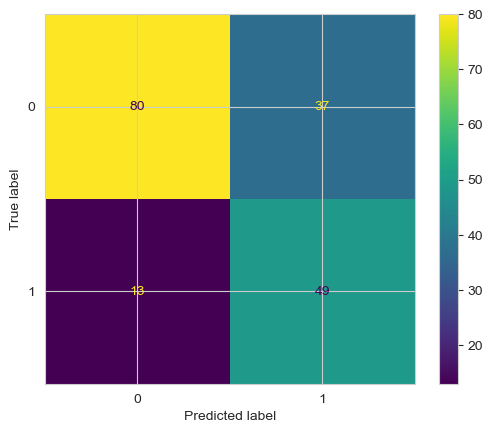

The test score is  0.7206703910614525
The precision score is  0.5697674418604651
The recall score is  0.7903225806451613
The f1 score is  0.6621621621621622
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       117
           1       0.57      0.79      0.66        62

    accuracy                           0.72       179
   macro avg       0.71      0.74      0.71       179
weighted avg       0.76      0.72      0.73       179



In [42]:
create_report(grid_model_log.best_estimator_, X_test, y_test)

## SGDClassifier

In [12]:
sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(X_train, y_train)
print("The score of our model is ", sgd_model.score(X_train, y_train))
cross_val_score(sgd_model, X_train, y_train)

The score of our model is  0.7907303370786517


array([0.71328671, 0.81118881, 0.80985915, 0.75352113, 0.76056338])

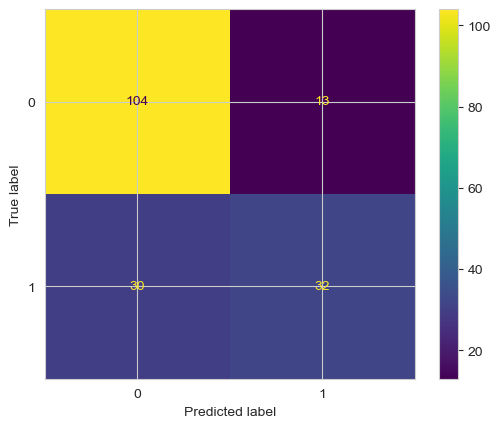

The test score is  0.7597765363128491
The precision score is  0.7111111111111111
The recall score is  0.5161290322580645
The f1 score is  0.5981308411214953
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       117
           1       0.71      0.52      0.60        62

    accuracy                           0.76       179
   macro avg       0.74      0.70      0.71       179
weighted avg       0.75      0.76      0.75       179



In [13]:
create_report(sgd_model, X_test, y_test)

## Decision Tree

In [14]:
dt_model = DecisionTreeClassifier(random_state=0, max_depth=2)
dt_model.fit(X_train, y_train)
print("The score of our model is ", dt_model.score(X_train, y_train))
cross_val_score(dt_model, X_train, y_train)

The score of our model is  0.7921348314606742


array([0.7972028 , 0.83216783, 0.8028169 , 0.76056338, 0.76760563])

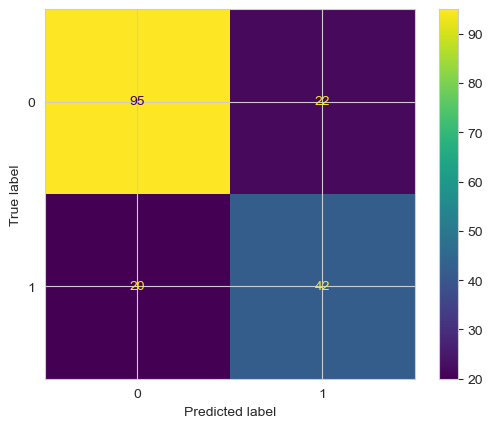

The test score is  0.7653631284916201
The precision score is  0.65625
The recall score is  0.6774193548387096
The f1 score is  0.6666666666666667
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       117
           1       0.66      0.68      0.67        62

    accuracy                           0.77       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.77      0.77      0.77       179



In [15]:
create_report(dt_model, X_test, y_test)

## Random Forest Classifier

In [16]:
random_forest = RandomForestClassifier(class_weight=class_weights)
random_forest.fit(X_train, y_train)
print("The score of our model is ", random_forest.score(X_train, y_train))
cross_val_score(random_forest, X_train, y_train)

The score of our model is  0.925561797752809


array([0.8041958 , 0.85314685, 0.86619718, 0.77464789, 0.77464789])

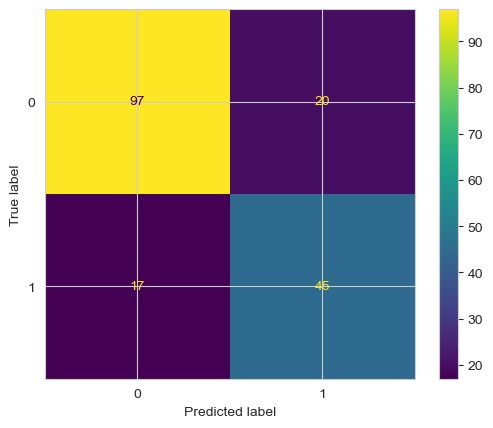

The test score is  0.7932960893854749
The precision score is  0.6923076923076923
The recall score is  0.7258064516129032
The f1 score is  0.7086614173228347
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       117
           1       0.69      0.73      0.71        62

    accuracy                           0.79       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.80      0.79      0.79       179



In [17]:
create_report(random_forest, X_test, y_test)

## SVM

In [18]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
print("The score of our model is ", svm_model.score(X_train, y_train))
cross_val_score(svm_model, X_train, y_train)

The score of our model is  0.8174157303370787


array([0.83216783, 0.84615385, 0.81690141, 0.77464789, 0.78873239])

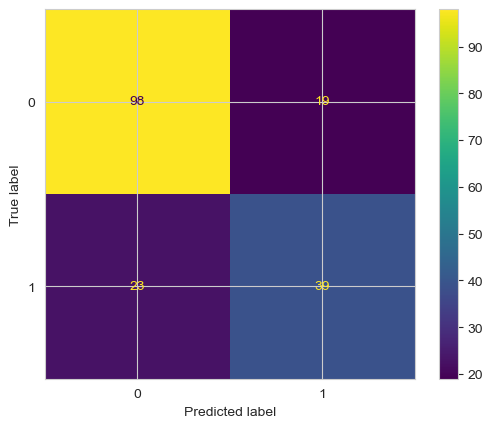

The test score is  0.7653631284916201
The precision score is  0.6724137931034483
The recall score is  0.6290322580645161
The f1 score is  0.6499999999999999
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       117
           1       0.67      0.63      0.65        62

    accuracy                           0.77       179
   macro avg       0.74      0.73      0.74       179
weighted avg       0.76      0.77      0.76       179



In [19]:
create_report(svm_model, X_test, y_test)

# Ensemble learning technique

## XGBoost

In [20]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
print("The score of our model is ", xgb_model.score(X_train, y_train))
cross_val_score(xgb_model, X_train, y_train)

The score of our model is  0.9129213483146067


array([0.81818182, 0.83216783, 0.85915493, 0.78873239, 0.78873239])

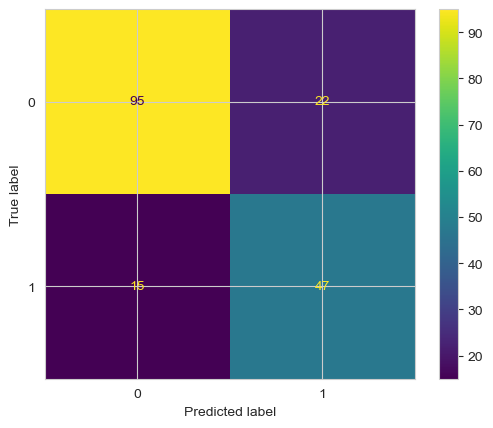

The test score is  0.7932960893854749
The precision score is  0.6811594202898551
The recall score is  0.7580645161290323
The f1 score is  0.7175572519083969
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       117
           1       0.68      0.76      0.72        62

    accuracy                           0.79       179
   macro avg       0.77      0.79      0.78       179
weighted avg       0.80      0.79      0.80       179



In [21]:
create_report(xgb_model, X_test, y_test)

## Stacking

In [22]:
base_estimators = [
    ('lr', lr_model),
    ('sgd', sgd_model),
    ('dt', dt_model)
]

ensemble_model = StackingClassifier(estimators=base_estimators)
ensemble_model.fit(X_train, y_train)
print("The score of our model is ", ensemble_model.score(X_train, y_train))
cross_val_score(ensemble_model, X_train, y_train)

The score of our model is  0.8089887640449438


array([0.79020979, 0.85314685, 0.81690141, 0.76760563, 0.76760563])

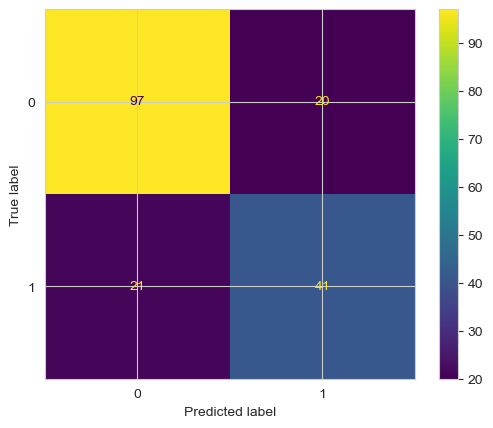

The test score is  0.770949720670391
The precision score is  0.6721311475409836
The recall score is  0.6612903225806451
The f1 score is  0.6666666666666666
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       117
           1       0.67      0.66      0.67        62

    accuracy                           0.77       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



In [23]:
create_report(ensemble_model, X_test, y_test)

## Bagging

In [24]:
bagging_classifier = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0)
bagging_classifier.fit(X_train, y_train)
print("The score of our model is ", bagging_classifier.score(X_train, y_train))
cross_val_score(bagging_classifier, X_train, y_train)

The score of our model is  0.8103932584269663


array([0.83216783, 0.84615385, 0.82394366, 0.78169014, 0.78873239])

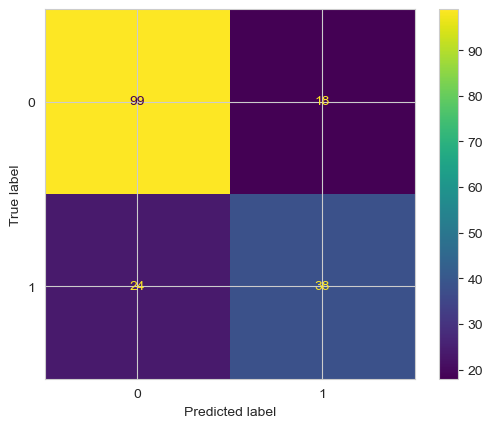

The test score is  0.7653631284916201
The precision score is  0.6785714285714286
The recall score is  0.6129032258064516
The f1 score is  0.6440677966101694
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       117
           1       0.68      0.61      0.64        62

    accuracy                           0.77       179
   macro avg       0.74      0.73      0.73       179
weighted avg       0.76      0.77      0.76       179



In [25]:
create_report(bagging_classifier, X_test, y_test)

# Create result for Kaggle

In [26]:
def load_titanic_test_preprocessed():
    test_preprocessed = pd.read_csv(os.path.join('data', 'test_preprocessed.csv'))
    test_preprocessed_features = test_preprocessed.drop('PassengerId', axis=1)
    test_preprocessed_label = test_preprocessed['PassengerId']
    return test_preprocessed_features, test_preprocessed_label

X_final, x_final_passenger_id = load_titanic_test_preprocessed()

random_forest.fit(X_test, y_test)
y_final = random_forest.predict(X_final)

df_final = pd.DataFrame(x_final_passenger_id)
df_final["Survived"] = y_final

filepath = Path('result.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_final.to_csv(filepath, index=False)